In [1]:
import time, os, json
import numpy as np
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt

from cs231n.classifiers.pretrained_cnn import PretrainedCNN
from cs231n.data_utils import load_tiny_imagenet
from cs231n.image_utils import blur_image, deprocess_image

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

/home/lizhe/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# TinyImageNet and pretrained model

In [2]:
data = load_tiny_imagenet('cs231n/datasets/tiny-imagenet-100-A', subtract_mean=True)
model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')

loading training data for synset 20 / 100
loading training data for synset 40 / 100
loading training data for synset 60 / 100
loading training data for synset 80 / 100
loading training data for synset 100 / 100


## Class visualization
在随机噪声图片上生成某种类的特征图

start with a random noise image and perform gradient ascent on a target class, we can generate an image that the network will recognize as the target class.

['tarantula']


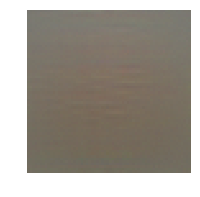

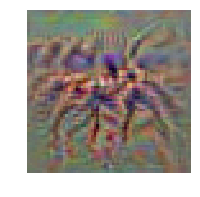

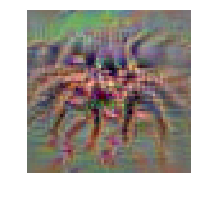

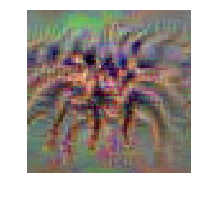

In [4]:
def create_class_visualization(target_y, model, **kwargs):
    learning_rate = kwargs.pop('learning_rate', 10000)
    blur_every = kwargs.pop('blur_every', 1)
    l2_reg = kwargs.pop('l2_reg', 1e-6)
    max_jiter = kwargs.pop('max_jiter', 4)
    num_iterations = kwargs.pop('num_iterations', 100)
    show_every = kwargs.pop('show_every', 25)
    
    X = np.random.randn(1, 3, 64, 64)
    for t in range(num_iterations):
        ox, oy = np.random.randint(-max_jiter, max_jiter+1, 2)
        X = np.roll(np.roll(X, ox, -1), oy, -2)
        
        scores, cache = model.forward(X, mode='test')
        dscores_target_y = np.zeros_like(scores)
        dscores_target_y[:, target_y] = 1
        dX, _ = model.backward(dscores_target_y, cache)
        dX -= 2*l2_reg*X
        X = X + learning_rate * dX
        
        X = np.roll(np.roll(X, -ox, -1), -oy, -2)
        X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
        
        if t % blur_every == 0:
            X = blur_image(X)
        if t % show_every == 0:
            plt.imshow(deprocess_image(X, data['mean_image']))
            plt.gcf().set_size_inches(3, 3)
            plt.axis('off')
            plt.show()
    return X

target_y = 43
print(data['class_names'][target_y])
X = create_class_visualization(target_y,model, show_every=25)

## Feature Inversion 

reconstruct features from fourth convolutional layer of the pretrained_model

/home/lizhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
/home/lizhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.


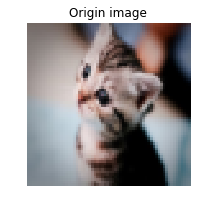

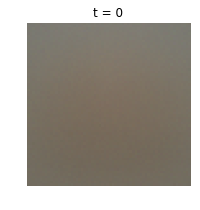

diff loss is: 258.12854


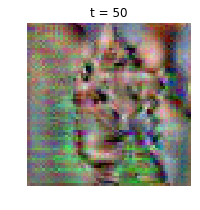

diff loss is: 69.207924


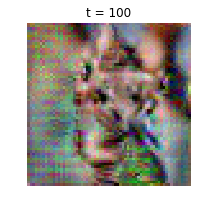

diff loss is: 39.722042


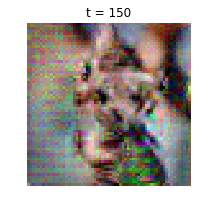

diff loss is: 23.844597


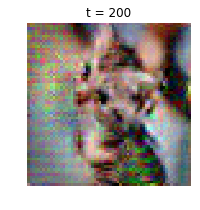

diff loss is: 27.974098


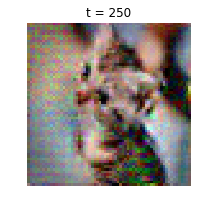

diff loss is: 12.442941


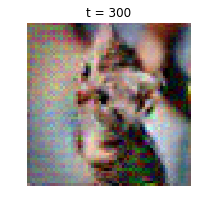

diff loss is: 19.501247


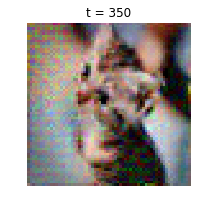

diff loss is: 8.454988


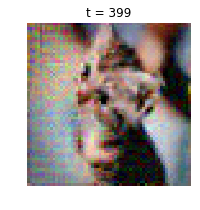

diff loss is: 18.762768


In [24]:
def invert_features(target_feats,layer, model, **kwargs):
    
    learning_rate = kwargs.pop('learning_rate', 10000)
    blur_every = kwargs.pop('blur_every', 1)
    l2_reg = kwargs.pop('l2_reg', 1e-7)
    num_iterations = kwargs.pop('num_iterations', 500)
    show_every = kwargs.pop('show_every', 50)
    
    X = np.random.randn(1, 3, 64, 64)
    for t in range(num_iterations):

        X = np.clip(X, -data['mean_image'], 255.0 - data['mean_image'])
        
        if t % blur_every == 0:
            X = blur_image(X)
        if t % show_every ==0 or t+1 == num_iterations:
            plt.imshow(deprocess_image(X, data['mean_image']))
            plt.gcf().set_size_inches(3, 3)
            plt.title('t = %d' % t)
            plt.axis('off')
            plt.show()
        
        current_feats, cache = model.forward(X, start=None, end=layer, mode='test')
        diff = current_feats - target_feats
        loss = np.sum(diff * diff)
        if t % show_every ==0 or t+1 == num_iterations:
            print('diff loss is:', loss)
        dout = 2 * diff
        dX, _ = model.backward(dout, cache)
        dX += 2*l2_reg*X
        X -= learning_rate * dX
#     return X

filename = 'kitten.jpg'
layer = 3
img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Origin image')
plt.axis('off')
plt.show()

from cs231n.image_utils import preprocess_image
img_pre = preprocess_image(img, data['mean_image'])
# plt.imshow(img_pre)
# plt.gcf().set_size_inches(3, 3)
# plt.title('img_pre')
# plt.axis('off')
# plt.show()

model = PretrainedCNN(h5_file='cs231n/datasets/pretrained_model.h5')
feats, _ = model.forward(img_pre, end=layer)

kwargs = {
  'num_iterations': 400,
  'learning_rate': 5000,
  #'learning_rate': 5000,
  'l2_reg': 1e-8,
  'show_every': 50,
  'blur_every': 10,
}

X = invert_features(feats, layer, model, **kwargs)

## deep feature reconstruction

/home/lizhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until
/home/lizhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  This is separate from the ipykernel package so we can avoid doing imports until


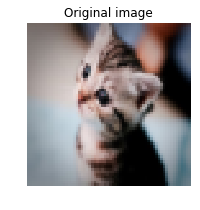

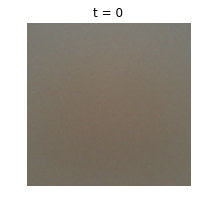

diff loss is: 12.023728


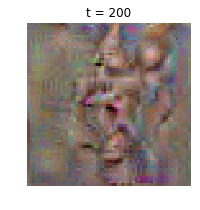

diff loss is: 0.9719969


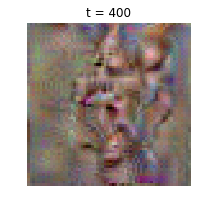

diff loss is: 0.5542384


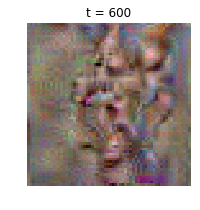

diff loss is: 0.44841382


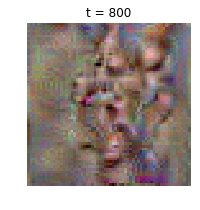

diff loss is: 0.3775288


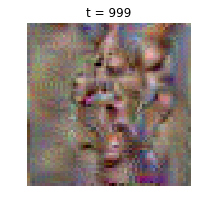

diff loss is: 0.31835777


In [25]:
filename = 'kitten.jpg'
layer = 6 # layers start from 0 so these are features after 7 convolutions
img = imresize(imread(filename), (64, 64))

plt.imshow(img)
plt.gcf().set_size_inches(3, 3)
plt.title('Original image')
plt.axis('off')
plt.show()

img_pre = preprocess_image(img, data['mean_image'])

feats, _ = model.forward(img_pre, end=layer)

kwargs = {
  'num_iterations': 1000,
  'learning_rate': 15000,
  'l2_reg': 1e-8,
  'show_every': 200,
  'blur_every': 200,
}
X = invert_features(feats, layer, model, **kwargs)

-----------layer0----------


/home/lizhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """
/home/lizhe/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """


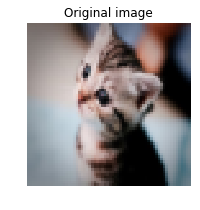

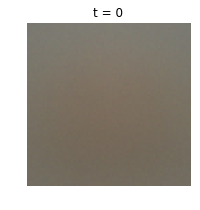

diff loss is: 931.9083


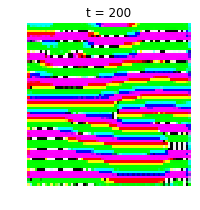

diff loss is: 43510.945


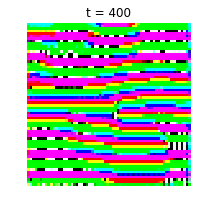

diff loss is: 43550.457


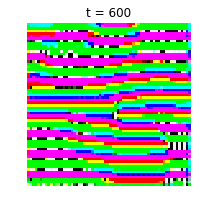

diff loss is: 43549.863


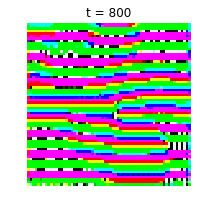

diff loss is: 43546.56


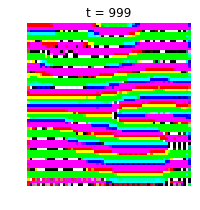

diff loss is: 45183.336
-----------layer1----------


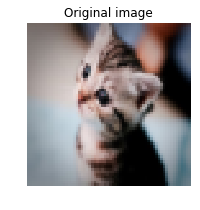

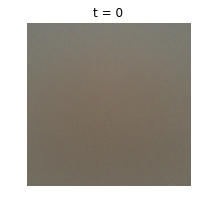

diff loss is: 689.30646


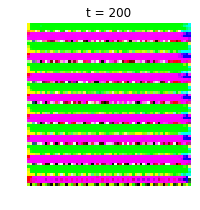

diff loss is: 41777.387


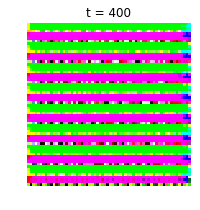

diff loss is: 41736.867


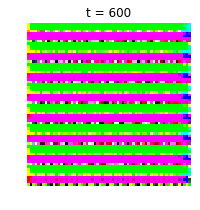

diff loss is: 41720.65


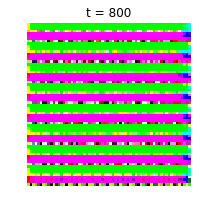

diff loss is: 41675.617


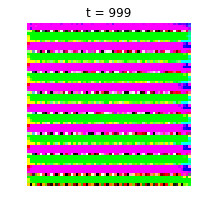

diff loss is: 42660.863
-----------layer2----------


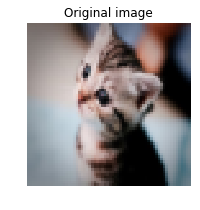

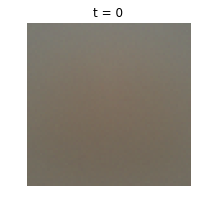

diff loss is: 304.29926


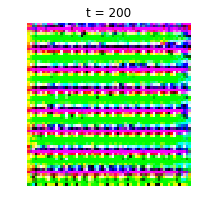

diff loss is: 11399.244


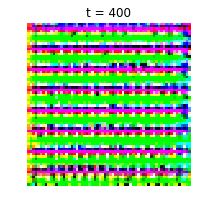

diff loss is: 11267.207


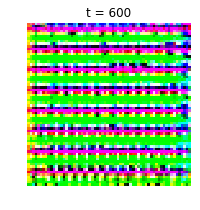

diff loss is: 11202.551


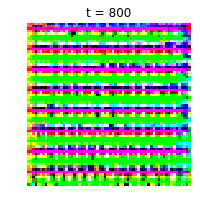

diff loss is: 11223.577


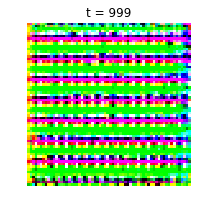

diff loss is: 11337.42
-----------layer3----------


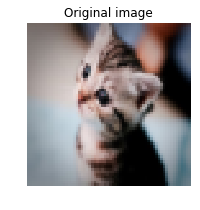

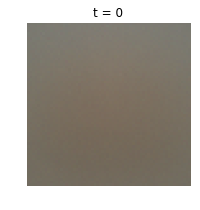

diff loss is: 257.9226


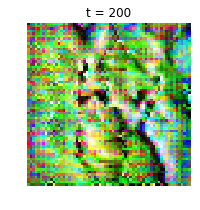

diff loss is: 124.36198


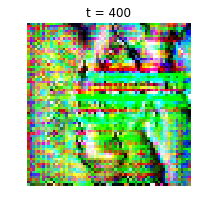

diff loss is: 823.58026


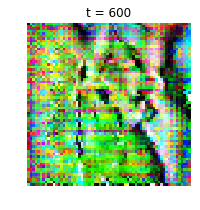

diff loss is: 193.43365


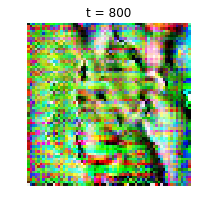

diff loss is: 314.65314


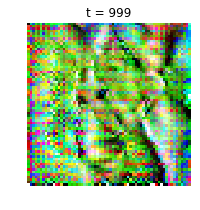

diff loss is: 116.294334
-----------layer4----------


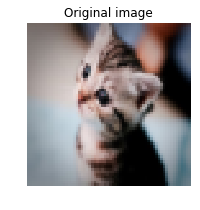

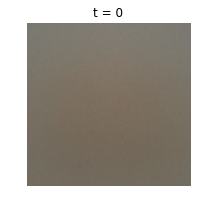

diff loss is: 82.01572


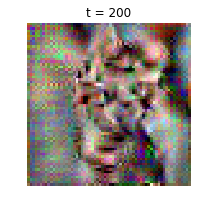

diff loss is: 5.6483307


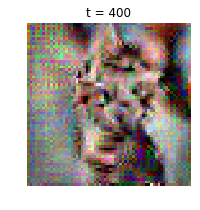

diff loss is: 2.8885493


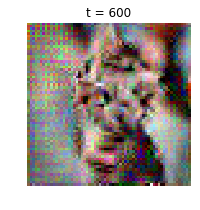

diff loss is: 2.297773


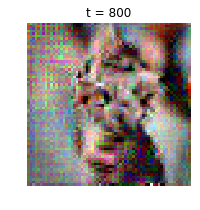

diff loss is: 1.8405439


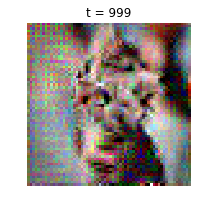

diff loss is: 1.386756
-----------layer5----------


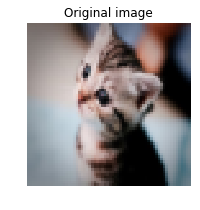

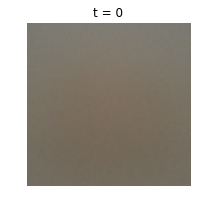

diff loss is: 48.403778


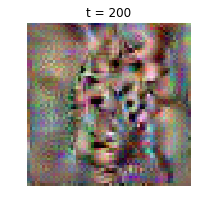

diff loss is: 3.2329836


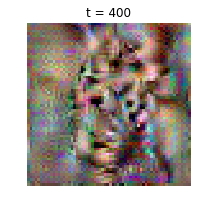

diff loss is: 1.9602412


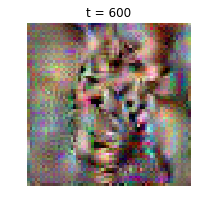

diff loss is: 1.5702765


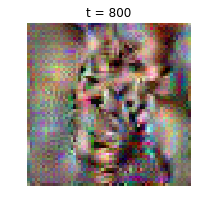

diff loss is: 2.0941992


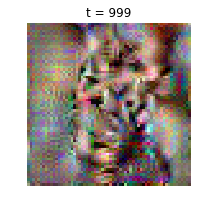

diff loss is: 1.3297155
-----------layer6----------


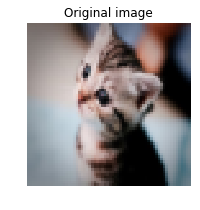

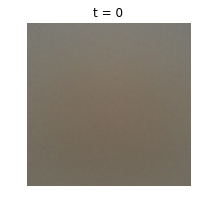

diff loss is: 12.022499


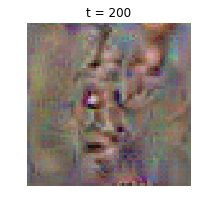

diff loss is: 1.2778106


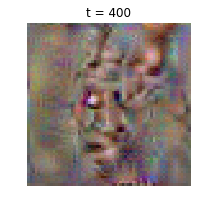

diff loss is: 0.5848245


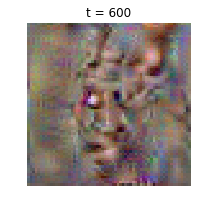

diff loss is: 0.47396415


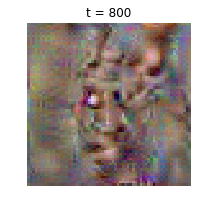

diff loss is: 0.35780397


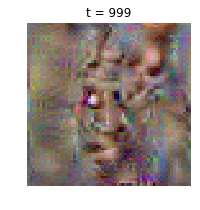

diff loss is: 0.2742132


In [26]:
for layer in range(7):
    print("-----------layer%d----------"% layer)
    filename = 'kitten.jpg'
    layer = layer
    img = imresize(imread(filename), (64, 64))

    plt.imshow(img)
    plt.gcf().set_size_inches(3, 3)
    plt.title('Original image')
    plt.axis('off')
    plt.show()

    img_pre = preprocess_image(img, data['mean_image'])

    feats, _ = model.forward(img_pre, end=layer)

    kwargs = {
      'num_iterations': 1000,
      'learning_rate': 15000,
      'l2_reg': 1e-8,
      'show_every': 200,
      'blur_every': 200,
    }
    X = invert_features(feats, layer, model, **kwargs)